# Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

In [6]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

**Setting the Data Path for Training and Testing Images**

In this task, we establish the file paths for the training and testing datasets. The dataset comprises approximately 2357 images categorized into 9 sub-directories within the train and test subdirectories. Each of these 9 sub-directories corresponds to a specific type of skin cancer.



In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
#Connect to google drive to get an access to the dataset
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
# Unzip the contents of the "CNN_assignment.zip" file located in the source directory
# "/content/gdrive/MyDrive/" and extract them into the destination directory
# "/content/gdrive/MyDrive/CNN_assignment". The "-o" flag is used to overwrite files
# in the destination directory if they already exist.
!unzip -o /content/gdrive/MyDrive/CNN_assignment.zip -d /content/gdrive/MyDrive/CNN_assignment


Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating

In [10]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [12]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [13]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [17]:
# Listing out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation

Creating a code to visualize all the nine classes present in the dataset

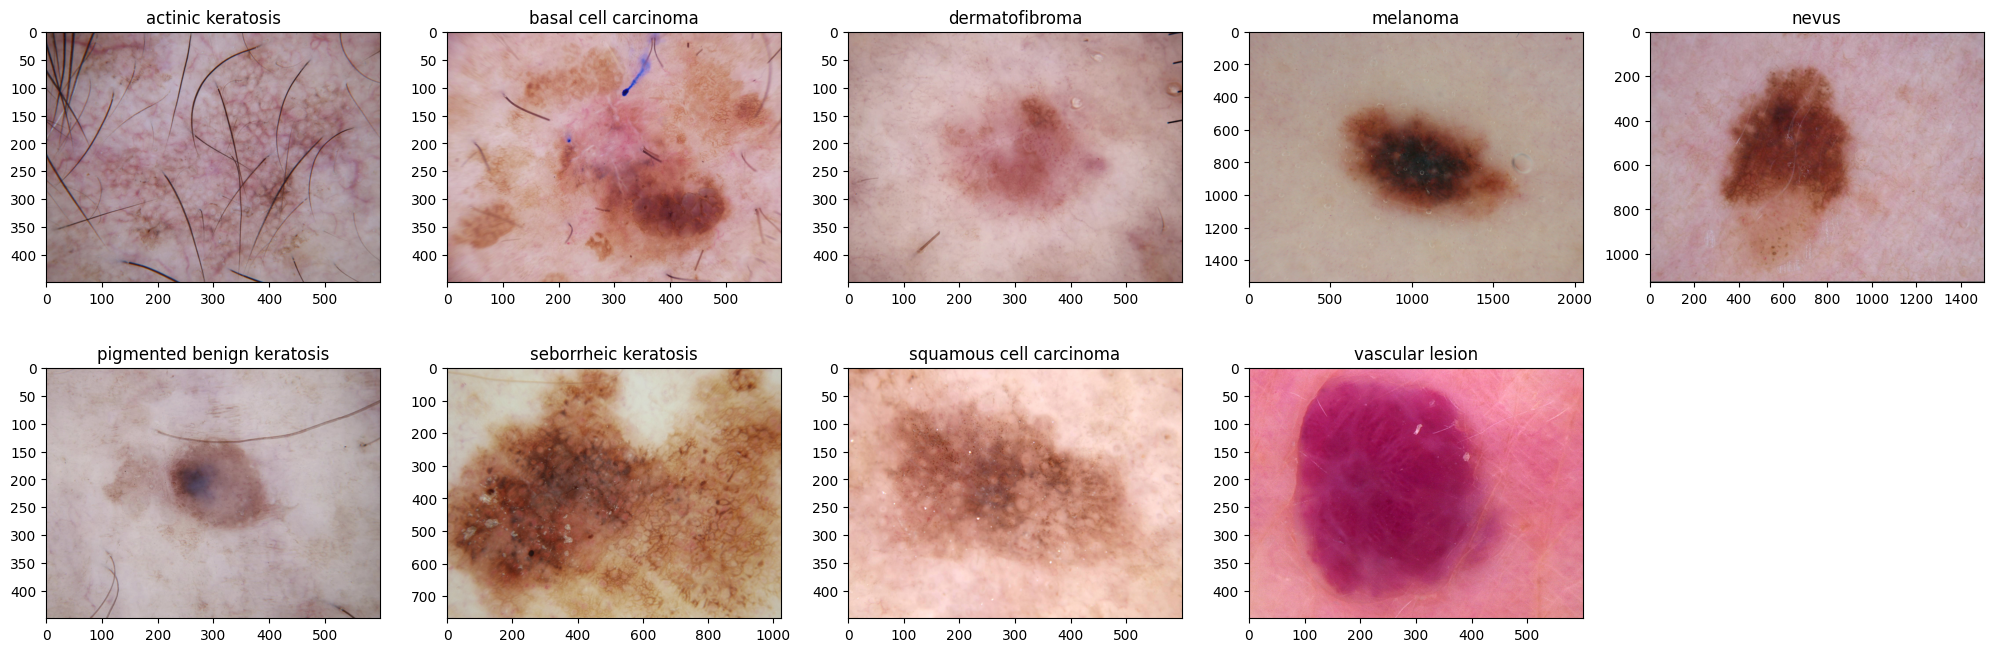

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [19]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Model Building & training :

* Creating a Convolutional Neural Network (CNN) model to accurately classify images into 9 different classes from a dataset. During model construction, ensuring that image pixel values are rescaled to fall within the range of 0 to 1 for normalization purposes.
* For training, selecting a suitable optimizer and loss function to optimize and measure the model's performance, respectively.
* Training the model for approximately 20 epochs to allow it to learn patterns in the data effectively.
* After training, visualizing the training and validation metrics on a graph to assess whether there are signs of either overfitting (where the model performs well on training data but poorly on new data) or underfitting (where the model struggles to learn from the training data). This graph helps in understanding how well the model generalizes to unseen data.

In [21]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [22]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [23]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 33s 154ms/step - loss: 3.1406 - accuracy: 0.2115 - val_loss: 2.0371 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: 1.9679 - accuracy: 0.2612 - val_loss: 1.7915 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6209 - accuracy: 0.4397 - val_loss: 1.5500 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.4259 - accuracy: 0.4961 - val_loss: 1.6669 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: 1.2678 - accuracy: 0.5564 - val_loss: 1.4580 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 4s 70ms/step - loss: 1.2212 - accuracy: 0.5882 - val_loss: 1.4409 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 4s 67ms/step - loss: 1.0918 - accuracy: 0.6138 - val_loss: 1.3863 - val_accuracy: 0.5369
Epoch 8/20


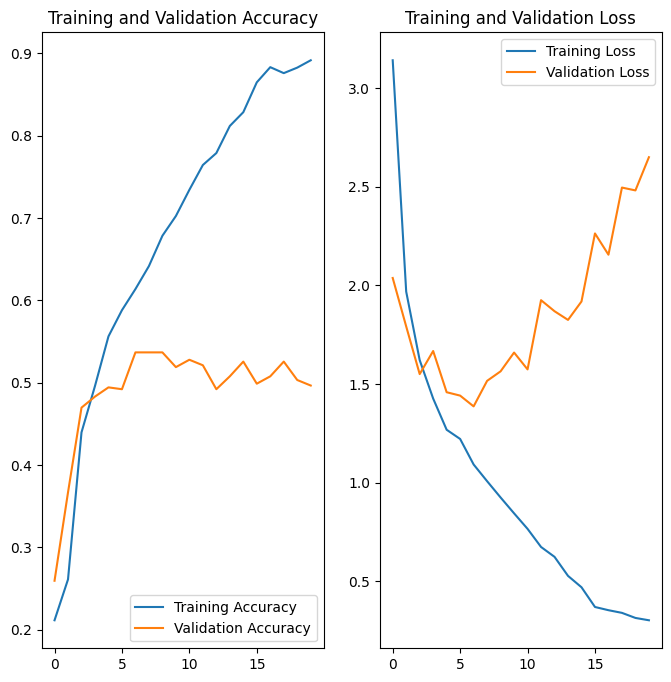

In [24]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Summary:</b>
        <ol>
            <li>Training accuracy steadily improves with each epoch, but validation accuracy plateaus at 50%.</li>
            <li>While training loss consistently decreases, validation loss starts increasing.</li>
            <li>The plots illustrate a significant gap between training and validation accuracy, with the model achieving approximately 50% accuracy on validation data.</li>
            <li>This noticeable difference in accuracy suggests potential overfitting.</li>
        </ol>
    </span>    
</div>

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

Overfitting typically happens when the training dataset is limited in size. To address this issue, data augmentation employs a strategy of creating extra training data by applying random transformations to the existing samples. These transformations produce new images that appear realistic and diverse. This approach aims to provide the model with a broader exposure to various aspects of the data, ultimately enhancing its ability to generalize effectively.

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

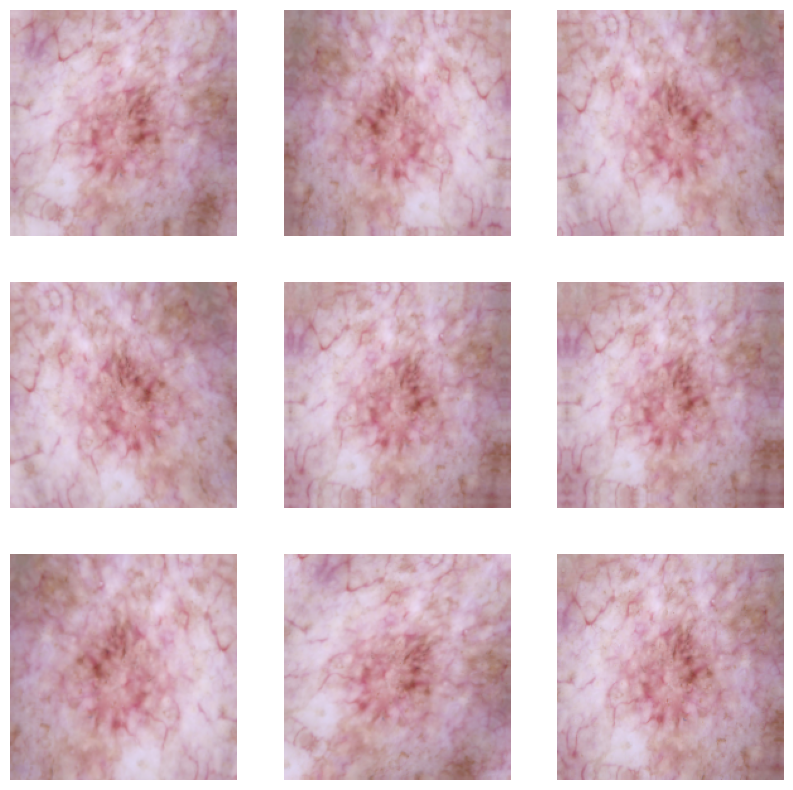

In [26]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data :

* Creating a Convolutional Neural Network (CNN) model to accurately classify images into 9 different classes from a dataset. During model construction, ensuring that image pixel values are rescaled to fall within the range of 0 to 1 for normalization purposes.
* For training, selecting a suitable optimizer and loss function to optimize and measure the model's performance, respectively.
* Training the model for approximately 20 epochs to allow it to learn patterns in the data effectively.
* After training, visualizing the training and validation metrics on a graph to assess whether there are signs of either overfitting (where the model performs well on training data but poorly on new data) or underfitting (where the model struggles to learn from the training data). This graph helps in understanding how well the model generalizes to unseen data.

In [27]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [28]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [29]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 76ms/step - loss: 3.1751 - accuracy: 0.2154 - val_loss: 1.8855 - val_accuracy: 0.3065
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.7476 - accuracy: 0.3638 - val_loss: 1.5904 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5169 - accuracy: 0.4671 - val_loss: 1.5431 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 1.4428 - accuracy: 0.4760 - val_loss: 1.4713 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 1.4082 - accuracy: 0.4989 - val_loss: 1.4393 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3585 - accuracy: 0.5179 - val_loss: 1.4774 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3348 - accuracy: 0.5223 - val_loss: 1.5107 - val_accuracy: 0.5123
Epoch 8/20
56

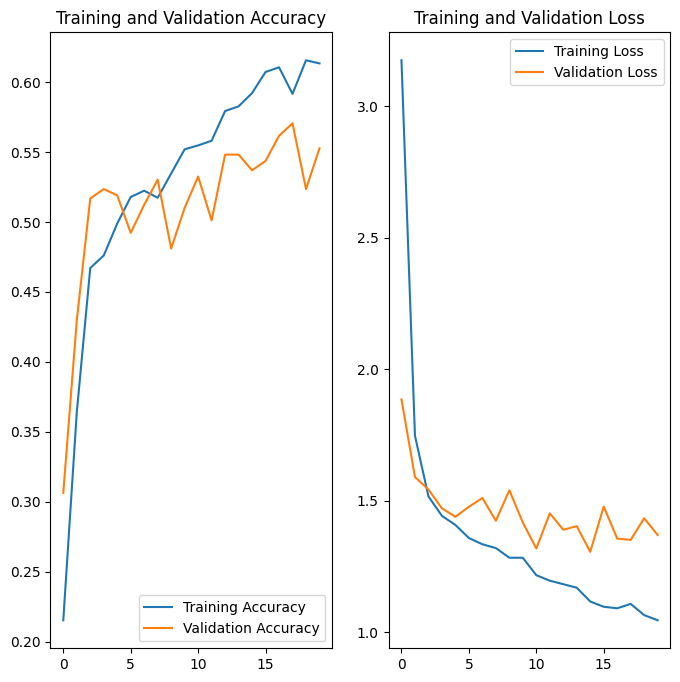

In [30]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Summary of Observations : </b>
        <ol>
            <li>During the training process, the accuracy of the model steadily increases, while the validation accuracy also rises but levels off at 55%.</li>
            <li>As the model trains over epochs, the training loss decreases, and the validation loss follows a similar trend by decreasing and stabilizing.</li>
            <li>The training and validation accuracy plots indicate a reduced gap compared to the previous model, achieving approximately 55% accuracy on the validation dataset.</li>
            <li>However, there is still a slightly noticeable difference between training and validation accuracy, suggesting a mild overfitting tendency.</li>
        </ol>
    </span>    
</div>


# Model Building & training on the augmented data with dropout :

* Creating a Convolutional Neural Network (CNN) model to accurately classify images into 9 different classes from a dataset. During model construction, ensuring that image pixel values are rescaled to fall within the range of 0 to 1 for normalization purposes.
* For training, selecting a suitable optimizer and loss function to optimize and measure the model's performance, respectively.
* Training the model for approximately 20 epochs to allow it to learn patterns in the data effectively.
* After training, visualizing the training and validation metrics on a graph to assess whether there are signs of either overfitting (where the model performs well on training data but poorly on new data) or underfitting (where the model struggles to learn from the training data). This graph helps in understanding how well the model generalizes to unseen data.

In [31]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [32]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [33]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 113ms/step - loss: 3.6747 - accuracy: 0.2768 - val_loss: 1.7455 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 6s 110ms/step - loss: 1.6518 - accuracy: 0.4096 - val_loss: 1.4826 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 6s 109ms/step - loss: 1.4650 - accuracy: 0.4810 - val_loss: 1.4951 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 1.4482 - accuracy: 0.4849 - val_loss: 1.4656 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 1.3734 - accuracy: 0.5134 - val_loss: 1.3974 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 6s 111ms/step - loss: 1.3166 - accuracy: 0.5329 - val_loss: 1.4320 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 6s 109ms/step - loss: 1.3201 - accuracy: 0.5346 - val_loss: 1.5626 - val_accuracy: 0.4922
Epoch 

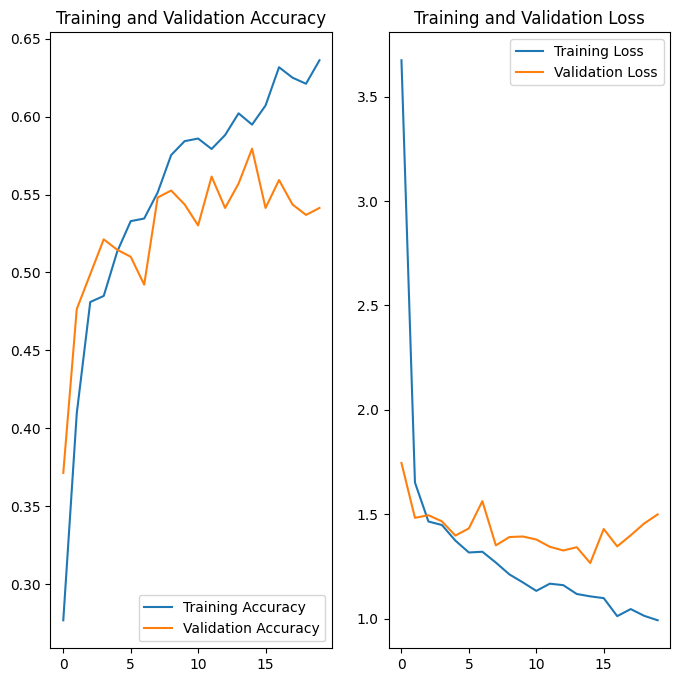

In [34]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Observations : </b>
        <ol>
            <li>Training accuracy consistently improves over time, while validation accuracy increases and then stabilizes at a 55% accuracy rate during the training process.</li>
            <li><b>Training loss decreases as the number of epochs increases, and this trend is mirrored in the validation loss.</b></li>
            <li>Examination of the plots reveals a reduction in the gap between training accuracy and validation accuracy compared to the previous model. The model has achieved an approximate <b>55%</b> accuracy on the validation set.</li>
            <li>The disparity in accuracy between training and validation data is <b>minimal</b>.</li>
        </ol>
    </span>  </div>





#### *It's evident that the extent of overfitting in the model has substantially diminished in comparison to the earlier models.*

# Class distribution:

Analyzing the present distribution of classes within the training dataset

Datasets often exhibit class imbalance, where one class may have a significantly larger number of samples compared to others.

Class imbalance can negatively impact the overall model quality. Therefore, it is crucial, as a preliminary check, to assess the distribution of classes within the dataset.

In [35]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Observations : </b>
        <ol>
            <li>Which category has the lowest sample count?<br>
            <b>The category "seborrheic keratosis" has the fewest samples with only 77.</b></li>
            <li>Which categories are dominant in terms of the proportion of samples?<br>
            <b>The categories "pigmented benign keratosis" stand out with a substantial 462 samples.</b></li>
        </ol>
    </span>    
</div>

# Handling class imbalances:

Rectifing class imbalances present in the training dataset with Augmentor library.

In [36]:
#Install Augmentor
!pip install Augmentor

In [37]:
path_to_training_dataset = "/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E144212B280>: 100%|██████████| 500/500 [00:20<00:00, 23.89 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E144222B010>: 100%|██████████| 500/500 [00:24<00:00, 20.53 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E14420D2650>: 100%|██████████| 500/500 [00:28<00:00, 17.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E14C0184AF0>: 100%|██████████| 500/500 [01:44<00:00,  4.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7E14C02B9A20>: 100%|██████████| 500/500 [01:20<00:00,  6.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E143777E1D0>: 100%|██████████| 500/500 [00:17<00:00, 28.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E147A9F51B0>: 100%|██████████| 500/500 [00:42<00:00, 11.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E14420AF670>: 100%|██████████| 500/500 [00:17<00:00, 27.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E145047C910>: 100%|██████████| 500/500 [00:17<00:00, 28.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Newly generated images with the Augmentor library:", image_count_train)

Newly generated images with the Augmentor library: 4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [40]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [41]:
df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [42]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building & training on the rectified class imbalance data :

* Creating a Convolutional Neural Network (CNN) model to accurately classify images into 9 different classes from a dataset. During model construction, ensuring that image pixel values are rescaled to fall within the range of 0 to 1 for normalization purposes.
* For training, selecting a suitable optimizer and loss function to optimize and measure the model's performance, respectively.
* Training the model for approximately 30 epochs to allow it to learn patterns in the data effectively.
* After training, visualizing the training and validation metrics on a graph to assess whether there are signs of either overfitting (where the model performs well on training data but poorly on new data) or underfitting (where the model struggles to learn from the training data). This graph helps in understanding how well the model generalizes to unseen data.

In [45]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [46]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [47]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 44s 242ms/step - loss: 2.2395 - accuracy: 0.3051 - val_loss: 1.5636 - val_accuracy: 0.4076
Epoch 2/30
169/169 [==============================] - 41s 235ms/step - loss: 1.5693 - accuracy: 0.4065 - val_loss: 1.4398 - val_accuracy: 0.4788
Epoch 3/30
169/169 [==============================] - 40s 230ms/step - loss: 1.4277 - accuracy: 0.4629 - val_loss: 1.3212 - val_accuracy: 0.4974
Epoch 4/30
169/169 [==============================] - 40s 229ms/step - loss: 1.3396 - accuracy: 0.4740 - val_loss: 1.2578 - val_accuracy: 0.5204
Epoch 5/30
169/169 [==============================] - 38s 220ms/step - loss: 1.2600 - accuracy: 0.5050 - val_loss: 1.2079 - val_accuracy: 0.5278
Epoch 6/30
169/169 [==============================] - 40s 228ms/step - loss: 1.2567 - accuracy: 0.5200 - val_loss: 1.2210 - val_accuracy: 0.5323
Epoch 7/30
169/169 [==============================] - 40s 231ms/step - loss: 1.2060 - accuracy: 0.5352 - val_loss: 1.2762 - val_ac

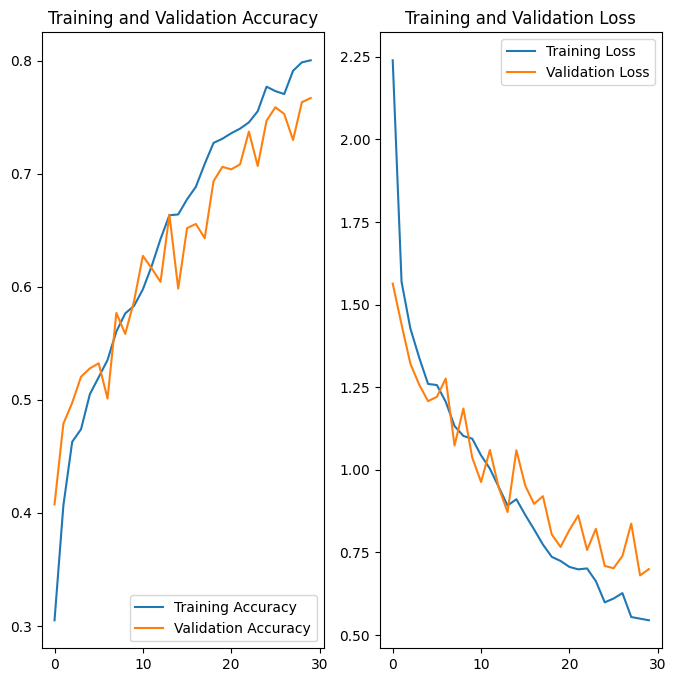

In [48]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Key Findings : </b>
        <ol>
            <li>Throughout the training process, both training accuracy and validation accuracy display a consistent rise.</li>
            <li>Furthermore, as training progresses, there is a steady decline in both training and validation losses.</li>
            <li>Compared to the previous model, the gap between training and validation accuracy has notably decreased, achieving approximately <b>75%</b> accuracy on the validation dataset.</li>
            <li>The variance in accuracy between training and validation is minimal.</li>
        </ol>
    </span>    
</div>

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <p>Implementing class rebalancing not only effectively addressed overfitting but also resulted in a substantial accuracy improvement, elevating it from 55% to 75%.</p>  
    </span>    
</div>
